In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .appName("Airline ML")\
    .config("spark.executor.memory","16g")\
    .config("spark.executor.cores","4")\
    .config("spark.driver.memory","6g")\
    .config("spark.executor.instances","5")\
    .config("spark.hadoop.fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")\
    .getOrCreate()

flight_df=spark.read.parquet(
  "s3a://ml-field/demo/flight-analysis/data/airline_parquet_2/",
)

flight_df = flight_df.na.drop().limit(100000)

In [2]:
flight_df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)



In [3]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf,substring

convert_time_to_hour = udf(lambda x: x if len(x) == 4 else "0{}".format(x),StringType())
#df.withColumn('COLUMN_NAME_fix',udf1('COLUMN_NAME')).show()

flight_df = flight_df.withColumn('CRS_DEP_HOUR', substring(convert_time_to_hour("CRS_DEP_TIME"),0,2))
flight_df = flight_df.withColumn('CRS_ARR_HOUR', substring(convert_time_to_hour("CRS_ARR_TIME"),0,2))


In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

numeric_cols = ["CRS_ELAPSED_TIME","DISTANCE"]

op_carrier_indexer = StringIndexer(inputCol ='OP_CARRIER', outputCol = 'OP_CARRIER_INDEXED',handleInvalid="keep")
op_carrier_encoder = OneHotEncoder(inputCol ='OP_CARRIER_INDEXED', outputCol='OP_CARRIER_ENCODED')

# op_carrier_fl_num_indexer = StringIndexer(inputCol ='OP_CARRIER_FL_NUM', outputCol = 'OP_CARRIER_FL_NUM_INDEXED',handleInvalid="keep")
# op_carrier_fl_num_encoder = OneHotEncoder(inputCol ='OP_CARRIER_FL_NUM_INDEXED', outputCol='OP_CARRIER_FL_NUM_ENCODED')

origin_indexer = StringIndexer(inputCol ='ORIGIN', outputCol = 'ORIGIN_INDEXED',handleInvalid="keep")
origin_encoder = OneHotEncoder(inputCol ='ORIGIN_INDEXED', outputCol='ORIGIN_ENCODED')

dest_indexer = StringIndexer(inputCol ='DEST', outputCol = 'DEST_INDEXED',handleInvalid="keep")
dest_encoder = OneHotEncoder(inputCol ='DEST_INDEXED', outputCol='DEST_ENCODED')

crs_dep_hour_indexer = StringIndexer(inputCol ='CRS_DEP_HOUR', outputCol = 'CRS_DEP_HOUR_INDEXED',handleInvalid="keep")
crs_dep_hour_encoder = OneHotEncoder(inputCol ='CRS_DEP_HOUR_INDEXED', outputCol='CRS_DEP_HOUR_ENCODED')

# crs_arr_hour_indexer = StringIndexer(inputCol ='CRS_ARR_HOUR', outputCol = 'CRS_ARR_HOUR_INDEXED',handleInvalid="keep")
# crs_arr_hour_encoder = OneHotEncoder(inputCol ='CRS_ARR_HOUR_INDEXED', outputCol='CRS_ARR_HOUR_ENCODED')

input_cols=[
    'OP_CARRIER_ENCODED',
    #'OP_CARRIER_FL_NUM_ENCODED',
    'ORIGIN_ENCODED',
    'DEST_ENCODED',
    'CRS_DEP_HOUR_ENCODED'] + numeric_cols
    #'CRS_ARR_HOUR_ENCODED'] + numeric_cols

assembler = VectorAssembler(
    inputCols = input_cols,
    outputCol = 'features')

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[op_carrier_indexer, 
                            op_carrier_encoder, 
                            #op_carrier_fl_num_indexer,
                            #op_carrier_fl_num_encoder,
                            origin_indexer,
                            origin_encoder,
                            dest_indexer,
                            dest_encoder,
                            crs_dep_hour_indexer,
                            crs_dep_hour_encoder,
                            #crs_arr_hour_indexer,
                            #crs_arr_hour_encoder,
                            assembler])

pipelineModel = pipeline.fit(flight_df)
model_df = pipelineModel.transform(flight_df)
selectedCols = ['CANCELLED', 'features']# + cols
model_df = model_df.select(selectedCols)
model_df.printSchema()
(train, test) = model_df.randomSplit([0.7, 0.3])



root
 |-- CANCELLED: double (nullable = true)
 |-- features: vector (nullable = true)



In [5]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'CANCELLED', maxIter=10)

lrModel = lr.fit(train)

In [25]:
print(lrModel.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial. (default: auto)
featuresCol: features column name (default: features, current: features)
fitIntercept: whether to fit an intercept term (default: True)
labelCol: label column name (default: label, current: CANCELLED)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. (undefined)
maxIter: maximum number of iterations (>= 0) (default: 100, current: 10)
predictionCol: prediction column name (default: prediction)
probabilityCol: Column name f

In [7]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictionslr = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED",metricName="areaUnderROC")
evaluator.evaluate(predictionslr)

0.8233458102297889

Training set areaUnderROC: 0.8562457832069122


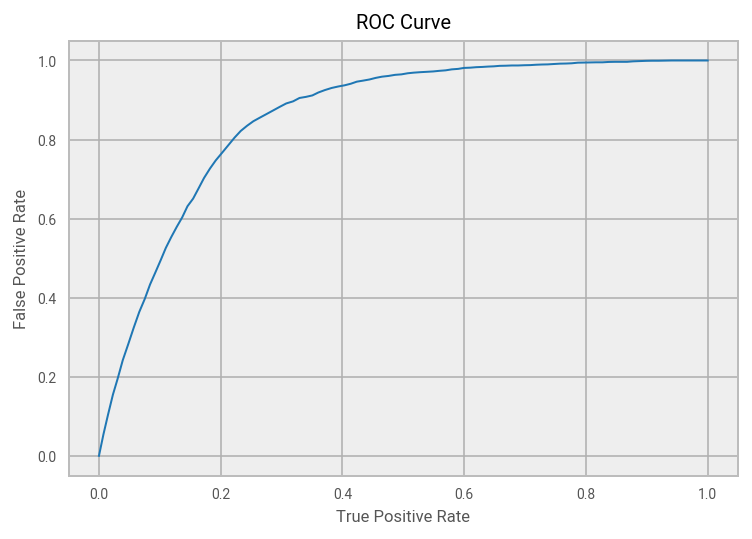

In [11]:
import matplotlib.pyplot as plt 
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [12]:
from pyspark.ml.classification import RandomForestClassifier

rfclassifier = RandomForestClassifier(labelCol = 'CANCELLED', featuresCol = 'features')
rfmodel = rfclassifier.fit(train)

In [13]:
predictionsrf = rfmodel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED",metricName="areaUnderROC")
evaluator.evaluate(predictionsrf)

0.733358099788284

In [14]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10,featuresCol = 'features', labelCol = 'CANCELLED')

gbtModel = gbt.fit(train)

In [15]:
predictionsgbt = gbtModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="CANCELLED",metricName="areaUnderROC")
evaluator.evaluate(predictionsgbt)

0.753775137187378

In [16]:
spark.stop()